
# Wind Rose Analysis Template

This notebook generates wind rose plots of average wind speed and direction** in the 6h and 12h windows prior to precipitation events, with the ability to:

- Filter by precipitation type: rain, snow, or both  
- Restrict analysis to specific months (e.g., snow season)  
- Dynamically parse CSVs that contain header metadata (e.g., MeteoBlue History+ exports)  
- Produce reusable plots for different customers/sites  



In [1]:
# --- Interactive Configuration UI (ipywidgets) ---
# pip install ipywidgets  # <- if needed

import glob, re, csv, warnings
from pathlib import Path

import pandas as pd
import ipywidgets as w
from IPython.display import display, clear_output
from pandas.api.types import is_numeric_dtype

warnings.filterwarnings("ignore", category=UserWarning)

# ============ Settings ============
VERBOSE_DEFAULT = False
HEADER_SCAN_LINES = 100          # scan this many lines to find header row
EVAL_SAMPLE_ROWS = 200           # rows to evaluate candidate header/data alignment
TIMESTAMP_SAMPLE_ROWS = 400      # rows to check timestamp parse
CANDIDATE_LIMIT = 12             # at most this many candidate header rows to evaluate

# ============ Helpers ============
def find_files(pattern: str):
    return sorted(glob.glob(pattern))

def month_strs_to_nums(names):
    month_map = {
        "Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4,
        "May": 5, "Jun": 6, "Jul": 7, "Aug": 8,
        "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12
    }
    out = []
    for m in names:
        key = str(m).strip().title()[:3]
        if key in month_map:
            out.append(month_map[key])
    return out

def _norm(s: str) -> str:
    s = str(s).strip().lower()
    s = s.replace("_", " ").replace("-", " ")
    s = re.sub(r"[^\w\s:/]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

# --- field rules / keywords ---
FIELD_RULES = {
    "timestamp": {
        "aliases": [
            "timestamp","time stamp","date time","datetime","date/time","date time (utc)","datetime (utc)",
            "valid time","valid","obs time","observation time","observed at","time local","local time",
            "utc","time","date","start time","end time"
        ],
        "avoid": ["elapsed","timezone","zone","offset","sunrise","sunset","duration","period"]
    },
    "wind_dir": {
        "aliases": ["wind direction","wind dir","wdir","dir (deg)","direction (deg)","dir","wind bearing","bearing"],
        "avoid":   ["std","variance","gust","speed"]
    },
    "wind_speed": {
        "aliases": ["wind speed","wspeed","wspd","ws","speed (m/s)","speed (mph)","speed","avg wind"],
        "avoid":   ["gust","direction","dir","bearing"]
    },
    "rain": {
        "aliases": ["rain","precipitation total","precip total","rainfall","rain amount","rain (mm)","rain (in)"],
        "avoid":   ["snow","snowfall","snow depth"]
    },
    "snow": {
        "aliases": ["snow","snowfall","snow fall","snow amount","snow depth","snow (mm)","snow (in)"],
        "avoid":   ["rain"]
    },
    "unified_precip": {
        "aliases": ["precipitation","total precip","precip total","precipitation total","ppt"],
        "avoid":   []
    }
}
# flatten keywords for heuristic header search
KEYWORDS = set()
for v in FIELD_RULES.values():
    for a in v["aliases"]:
        KEYWORDS.update(_norm(a).split())
KEYWORDS.update(["wind","precip","snow","dir","speed","rain","gust"])

BAD_TS_NAMES = {"variable","variables","category","name","parameter","sensor","station","site","location id"}

def _score_header_token_line(tokens):
    # tokens: list of header fields (normalized already)
    score = 0
    for t in tokens:
        if any(k in t for k in KEYWORDS):
            score += 1
    # distinctness: avoid lines where most tokens repeat (e.g., 'La Sal','La Sal.1',..)
    distinct = len(set(tokens))
    total    = len(tokens) if tokens else 1
    distinct_ratio = distinct / total
    score += int(5 * distinct_ratio)  # up to +5
    return score

def _detect_delimiter(lines):
    cand = [",",";","\t","|"]
    if not lines:
        return ","
    # pick best by frequency across first few lines
    freq_best = max(cand, key=lambda d: sum(ln.count(d) for ln in lines[:20]))
    return freq_best

def _sniff_header_row_and_delim(path):
    """Return (header_row_idx, delimiter). Robust to metadata before header."""
    try:
        with open(path, "r", encoding="utf-8-sig", errors="ignore") as f:
            raw = f.read(65536)  # 64KB
    except Exception:
        return 0, ","
    lines = [ln.rstrip("\n\r") for ln in raw.splitlines()]
    if not lines:
        return 0, ","
    delim = _detect_delimiter(lines)

    # Build candidate indices: those with >=2 fields and containing some keywords
    cands = []
    for i, ln in enumerate(lines[:HEADER_SCAN_LINES]):
        if not ln.strip():
            continue
        toks = [ _norm(t) for t in ln.split(delim) if t.strip() ]
        if len(toks) < 2:
            continue
        token_score = _score_header_token_line(toks)
        # prefer rows with any keyword or good distinctness
        if token_score >= 3 or any(k in " ".join(toks) for k in KEYWORDS):
            cands.append((i, token_score))

    # If none matched keywords, fall back to any line with at least 2 tokens
    if not cands:
        for i, ln in enumerate(lines[:HEADER_SCAN_LINES]):
            toks = [ _norm(t) for t in ln.split(delim) if t.strip() ]
            if len(toks) >= 2:
                cands.append((i, _score_header_token_line(toks)))
    # Sort by token score (desc), then by index (prefer earlier)
    cands = sorted(cands, key=lambda x: (-x[1], x[0]))[:CANDIDATE_LIMIT]

    # Evaluate candidates by actually reading a small sample under that header
    best_idx, best_score = 0, -1e9
    for idx, tok_score in cands:
        try:
            df_try = pd.read_csv(
                path, sep=delim, engine="python", encoding="utf-8-sig",
                header=idx, nrows=EVAL_SAMPLE_ROWS, on_bad_lines="skip"
            )
            if df_try.empty or len(df_try.columns) < 2:
                continue
            # compute simple data alignment score:
            # - max datetime parse rate across columns
            # - median numeric parse rate across columns
            dt_rates, num_rates = [], []
            for c in df_try.columns:
                s = df_try[c]
                # datetime parse rate
                try:
                    dt_rate = pd.to_datetime(s, errors="coerce", utc=True).notna().mean()
                except Exception:
                    dt_rate = 0.0
                dt_rates.append(float(dt_rate))
                # numeric parse rate
                try:
                    num_rate = pd.to_numeric(s, errors="coerce").notna().mean()
                except Exception:
                    num_rate = 0.0
                num_rates.append(float(num_rate))
            max_dt = max(dt_rates) if dt_rates else 0.0
            med_num = float(pd.Series(num_rates).median()) if num_rates else 0.0
            # final candidate score: token_score + weights for data alignment
            cand_score = tok_score + 8.0*max_dt + 2.0*med_num
            if cand_score > best_score:
                best_score, best_idx = cand_score, idx
        except Exception:
            continue

    return best_idx, delim

def _read_csv_lenient(path, header_row=None, delim=None, **kwargs):
    """Read CSV using detected header row and delimiter (robust to metadata)."""
    if header_row is None or delim is None:
        header_row, delim = _sniff_header_row_and_delim(path)
    return pd.read_csv(
        path, sep=delim, engine="python", encoding="utf-8-sig",
        header=header_row, **kwargs
    )

# --- timestamp detection ---
def _score_epoch_series(s: pd.Series):
    try:
        s_num = pd.to_numeric(s, errors="coerce").dropna()
        if s_num.empty:
            return 0.0
        ratios = []
        for unit, (lo, hi) in {
            "s": (10**9, 10**10),
            "ms": (10**12, 10**13),
            "us": (10**15, 10**16),
        }.items():
            mask = (s_num > lo) & (s_num < hi)
            if mask.any():
                ratios.append(pd.to_datetime(s_num[mask], unit=unit, errors="coerce").notna().mean())
        return max(ratios) if ratios else 0.0
    except Exception:
        return 0.0

def _score_datetime_series(s: pd.Series):
    try:
        return pd.to_datetime(s, errors="coerce", utc=True).notna().mean()
    except Exception:
        return 0.0

def _score_header(name: str, aliases, avoid) -> int:
    n = _norm(name)
    score = 0
    for a in aliases:
        if a in n:
            score += 2 + min(3, len(a.split()) - 1)
    for bad in avoid:
        if bad in n:
            score -= 3
    if n in BAD_TS_NAMES:
        score -= 5
    return score

def _detect_timestamp(paths, cols, header_row=None, delim=None):
    """Pick the best timestamp column using header + data under the true header row."""
    if not paths or not cols:
        return None
    try:
        df_sample = _read_csv_lenient(paths[0], header_row, delim, nrows=TIMESTAMP_SAMPLE_ROWS, on_bad_lines="skip")
    except Exception:
        df_sample = None

    best_col, best_total = None, -1e9
    for c in cols:
        h = _score_header(c, FIELD_RULES["timestamp"]["aliases"], FIELD_RULES["timestamp"]["avoid"])
        d = 0.0
        if df_sample is not None and c in df_sample.columns:
            s = df_sample[c]
            d = _score_epoch_series(s) if is_numeric_dtype(s) else _score_datetime_series(s)
        total = h + 10.0*d
        if total > best_total:
            best_total, best_col = total, c

    # Require minimal evidence: header match or >=30% parse success
    if best_col is not None:
        hs = _score_header(best_col, FIELD_RULES["timestamp"]["aliases"], FIELD_RULES["timestamp"]["avoid"])
        ds = 0.0
        if df_sample is not None and best_col in df_sample.columns:
            s = df_sample[best_col]
            ds = _score_epoch_series(s) if is_numeric_dtype(s) else _score_datetime_series(s)
        if hs >= 1 or ds >= 0.30:
            return best_col
    return None

# ============ Auto-detect mapping ============
def _read_headers(paths, max_files=5):
    cols, seen = [], set()
    for p in list(paths)[:max_files]:
        hdr_idx, delim = _sniff_header_row_and_delim(p)
        try:
            df0 = _read_csv_lenient(p, hdr_idx, delim, nrows=0)
            for c in list(df0.columns):
                if c not in seen:
                    seen.add(c); cols.append(c)
        except Exception:
            continue
    return cols

def _score_breakdown(cols, field, rules):
    scored = [(c, _score_header(c, rules["aliases"], rules["avoid"])) for c in cols]
    scored.sort(key=lambda x: x[1], reverse=True)
    return scored

def propose_column_mapping(paths):
    if not paths:
        return {}, [], {}
    # Use the first file to decide header_row/delim for content-aware checks
    hdr_idx, delim = _sniff_header_row_and_delim(paths[0])
    # Collect union of headers across a few files
    cols = _read_headers(paths)
    if not cols:
        return {}, [], {}

    mapping = {}
    scores_per_field = {}
    for field, rules in FIELD_RULES.items():
        scored = _score_breakdown(cols, field, rules)
        scores_per_field[field] = scored
        best = scored[0] if scored else (None, -999)
        mapping[field] = best[0] if best[1] >= 0 else None

    # Content-aware timestamp overrides header guess
    ts = _detect_timestamp(paths, cols, header_row=hdr_idx, delim=delim)
    if ts:
        mapping["timestamp"] = ts

    # Ensure wind_speed isn't a gust column
    ws = mapping.get("wind_speed")
    if ws and "gust" in _norm(ws or ""):
        for c, s in scores_per_field.get("wind_speed", []):
            if s >= 0 and "gust" not in _norm(c):
                mapping["wind_speed"] = c
                break

    return mapping, cols, {"header_row": hdr_idx, "delimiter": delim}

# ============ Widgets ============
# Data files
data_glob = w.Text(
    value="/content/*.csv",
    description="Data glob:",
    layout=w.Layout(width="60%")
)
refresh_data_btn = w.Button(description="Refresh files", icon="refresh")
data_files = w.SelectMultiple(
    options=find_files(data_glob.value),
    description="Data CSVs:",
    layout=w.Layout(width="60%", height="160px")
)

# Customer/Site
customer_name = w.Text(value="Example Resort", description="Customer:")
site_name     = w.Text(value="La Sal", description="Site:")

# Precip + hours
precip_types = w.SelectMultiple(
    options=["rain", "snow", "both"],
    value=["rain", "snow"],
    description="Precip:"
)
hours_before = w.SelectMultiple(
    options=[6, 12, 24],
    value=[6, 12],
    description="Hours:"
)

# Month filter: choose CSV or manual picker
month_mode = w.ToggleButtons(
    options=[("From CSV", "csv"), ("Pick Months", "pick")],
    value="csv",
    description="Months:"
)

months_glob = w.Text(
    value="/content/months*.csv",
    description="Months glob:",
    layout=w.Layout(width="60%")
)
refresh_months_btn = w.Button(description="Refresh months", icon="refresh")
months_file = w.Dropdown(
    options=find_files(months_glob.value),
    description="Months CSV:",
    layout=w.Layout(width="60%")
)

month_picker = w.SelectMultiple(
    options=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],
    value=["Dec","Jan","Feb"],
    description="Pick:",
    disabled=True
)

def on_month_mode_change(change):
    use_csv = (change["new"] == "csv")
    months_glob.disabled = not use_csv
    months_file.disabled = not use_csv
    refresh_months_btn.disabled = not use_csv
    month_picker.disabled = use_csv

month_mode.observe(on_month_mode_change, names="value")

# Column mapping widgets (start BLANK; filled by Auto-detect)
timestamp_col = w.Text(value="", placeholder="timestamp / datetime / time", description="Timestamp:")
wdir_col      = w.Text(value="", placeholder="Wind Direction", description="Wind Dir:")
wspeed_col    = w.Text(value="", placeholder="Wind Speed", description="Wind Spd:")
rain_col      = w.Text(value="", placeholder="Rain or Precip Total", description="Rain col:")
snow_col      = w.Text(value="", placeholder="Snowfall Amount", description="Snow col:")
precip_col    = w.Text(value="", placeholder="Precipitation (unified)", description="Unified:")

# Output dir
output_dir = w.Text(value="output", description="Output dir:")

# Action buttons / output
auto_detect_btn  = w.Button(description="Auto-detect columns", icon="magic", button_style="info")
overwrite_toggle = w.Checkbox(value=True, description="Overwrite manual entries")
verbose_toggle   = w.Checkbox(value=VERBOSE_DEFAULT, description="Verbose logs")
apply_btn        = w.Button(description="Apply configuration", button_style="success", icon="check")
msg_area         = w.Output()

# ============ Auto-detect handlers ============
def _maybe_set(widget: w.Text, new_val: str):
    if not new_val:
        return
    if overwrite_toggle.value or not widget.value.strip():
        widget.value = new_val

def _apply_mapping_to_widgets(mapping):
    _maybe_set(timestamp_col, mapping.get("timestamp"))
    _maybe_set(wdir_col,      mapping.get("wind_dir"))
    _maybe_set(wspeed_col,    mapping.get("wind_speed"))
    _maybe_set(rain_col,      mapping.get("rain"))
    _maybe_set(snow_col,      mapping.get("snow"))
    _maybe_set(precip_col,    mapping.get("unified_precip"))

def auto_detect_columns(_=None):
    with msg_area:
        clear_output()
        csvs = list(data_files.value)
        if not csvs and data_files.options:
            csvs = list(data_files.options)[:5]
            try:
                data_files.value = tuple(csvs)
            except Exception:
                pass
        if not csvs:
            print(" Select at least one CSV.")
            return

        mapping, cols, hdr_info = propose_column_mapping(csvs)
        if not cols:
            print(" Could not detect headers. Check delimiter or file format.")
            return

        _apply_mapping_to_widgets(mapping)

        # Minimal output
        print(
            " Auto-detected:",
            {
                "timestamp": timestamp_col.value,
                "wind_dir":  wdir_col.value,
                "wind_speed": wspeed_col.value,
                "rain":      rain_col.value,
                "snow":      snow_col.value,
                "unified_precip": precip_col.value,
            }
        )
        if verbose_toggle.value:
            print(f"Header row index: {hdr_info.get('header_row')}  Delimiter: {repr(hdr_info.get('delimiter'))}")

auto_detect_btn.on_click(auto_detect_columns)

# ============ Callbacks ============
def refresh_data(_):
    data_files.options = find_files(data_glob.value)

def refresh_months(_):
    months_file.options = find_files(months_glob.value)

refresh_data_btn.on_click(refresh_data)
refresh_months_btn.on_click(refresh_months)

def _auto_select_months_csv_if_needed():
    try:
        if months_file.value:
            return
        for p in months_file.options or []:
            try:
                df0 = _read_csv_lenient(p, nrows=0)
                if "Month" in df0.columns:
                    months_file.value = p
                    return
            except Exception:
                continue
    except Exception:
        pass

def apply_config(_):
    with msg_area:
        clear_output()

        # Resolve CSV_FILES
        csvs = list(data_files.value)
        if not csvs:
            print(" No data files selected. Click Refresh files, select, then Apply.")
            return

        # Resolve MONTH_FILTER
        if month_mode.value == "csv":
            _auto_select_months_csv_if_needed()
            if not months_file.value:
                print(" No months CSV found. Adjust months glob or switch to 'Pick Months'.")
                return
            months_path = months_file.value if isinstance(months_file.value, str) else months_file.value[0]
            try:
                mdf = _read_csv_lenient(months_path)
            except Exception as e:
                print(f" Failed to read months CSV: {e}")
                return
            if "Month" not in mdf.columns:
                print(" Months CSV must contain a 'Month' column (e.g., Jan, Feb, ...).")
                return
            month_filter_vals = month_strs_to_nums(mdf["Month"])
        else:
            month_filter_vals = month_strs_to_nums(list(month_picker.value))

        # Optional: validate chosen columns exist under the detected header
        try:
            hdr_idx, delim = _sniff_header_row_and_delim(csvs[0])
            df0 = _read_csv_lenient(csvs[0], hdr_idx, delim, nrows=0)
            headers0 = set(df0.columns)
            chosen = {
                "timestamp": timestamp_col.value,
                "wind_dir":  wdir_col.value,
                "wind_speed": wspeed_col.value,
                "rain":       rain_col.value,
                "snow":       snow_col.value,
                "unified_precip": precip_col.value,
            }
            missing = {k: v for k, v in chosen.items() if v and v not in headers0}
            if missing and verbose_toggle.value:
                print(" Warning: these columns aren’t present in the first CSV:", missing)
        except Exception:
            pass

        # Export to globals() for the rest of the notebook
        globals().update({
            "CSV_FILES": csvs,
            "CUSTOMER_NAME": customer_name.value,
            "SITE_NAME": site_name.value,
            "PRECIP_TYPES": list(precip_types.value),
            "HOURS_BEFORE": list(hours_before.value),
            "MONTH_FILTER": month_filter_vals,
            "TIMESTAMP_COL": timestamp_col.value,
            "WIND_DIR_COL": wdir_col.value,
            "WIND_SPEED_COL": wspeed_col.value,
            "RAIN_COL": rain_col.value,
            "SNOW_COL": snow_col.value,
            "PRECIP_COL": precip_col.value,
            "OUTPUT_DIR": output_dir.value,
        })

        print(" Configuration applied.")

apply_btn.on_click(apply_config)

# ============ Layout ============
data_row   = w.HBox([data_glob, refresh_data_btn])
data_list  = w.VBox([data_row, data_files])

months_row = w.HBox([months_glob, refresh_months_btn])
months_box = w.VBox([month_mode, months_row, months_file, month_picker])

cols_box = w.VBox([timestamp_col, wdir_col, wspeed_col, rain_col, snow_col, precip_col])

ui = w.VBox([
    w.HTML("<h3>Interactive Configuration</h3>"),
    data_list,
    w.HBox([customer_name, site_name]),
    w.HBox([precip_types, hours_before]),
    months_box,
    cols_box,
    output_dir,
    w.HBox([auto_detect_btn, apply_btn]),
    msg_area
])

display(ui)


In [2]:
try:
    import windrose
except ImportError:
    !pip install windrose
    import windrose


In [7]:

# === Imports ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from windrose import WindroseAxes
from pathlib import Path

# === Plot constants ===
WIND_SPEED_BINS = list(range(0, 40, 10))  # 0..100 in steps of 10
NSECTOR = 16

# Ensure output directory exists

OUTPUT_DIR = globals().get("OUTPUT_DIR", "output")  # fallback to ./output
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)


### Utilities

In [3]:

def detect_header_row(csv_path, header_key="timestamp"):
    """Return the 0-based line number where the actual header starts (default startswith 'timestamp')."""
    header_row = None
    with open(csv_path, "r", encoding="utf-8", errors="ignore") as f:
        for i, line in enumerate(f):
            if line.strip().lower().startswith(header_key):
                header_row = i
                break
    return header_row


def load_historylike_csv(csv_path, timestamp_col):
    """Load a CSV that may contain top metadata rows (like MeteoBlue History+)."""
    header_row = detect_header_row(csv_path, header_key="timestamp")
    if header_row is None:
        # Fallback: assume first row is header
        df = pd.read_csv(csv_path)
    else:
        df = pd.read_csv(csv_path, skiprows=header_row)
    # Parse timestamp
    if timestamp_col in df.columns:
        df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors="coerce")
        df = df.dropna(subset=[timestamp_col])
    else:
        raise KeyError(f"Timestamp column '{timestamp_col}' not found in {csv_path}. Columns: {list(df.columns)}")
    return df


def simplify_column_names(df):
    """Optionally simplify long site-prefixed column names, e.g. 'La Sal Temperature [2 m ...]' -> 'Temperature'."""
    def _clean(col):
        # Remove site prefix up to first space if it matches '[Site] Something ...'
        parts = str(col).split(" ", 1)
        if len(parts) > 1 and ("[" in parts[1] or parts[0].istitle()):
            candidate = parts[1]
        else:
            candidate = str(col)
        # Drop bracketed qualifiers
        candidate = candidate.split("[")[0].strip()
        return candidate
    return df.rename(columns={c: _clean(c) for c in df.columns})


### Wind vector averaging

In [4]:
def vector_average_direction(degrees_series: pd.Series) -> float:
    """Average wind direction using vector mean (0-360 degrees)."""
    import pandas as pd
    rad = np.deg2rad(degrees_series.dropna().values)
    if rad.size == 0:
        return np.nan
    u = np.cos(rad).mean()
    v = np.sin(rad).mean()
    ang = (np.rad2deg(np.arctan2(v, u)) + 360) % 360
    return ang

### Filtering by precipitation type and month; averaging winds in lead windows

In [5]:
def apply_month_filter(df: pd.DataFrame, months):
    if not months:
        return df
    if "Month" not in df.columns:
        df["Month"] = df[TIMESTAMP_COL].dt.month
    return df[df["Month"].isin(months)].copy()


def filter_by_precip_type(df: pd.DataFrame, precip_type: str) -> pd.DataFrame:
    """
    Return only rows for the selected precip type and attach a unified PRECIP_COL.
    Uses numeric coercion for robustness.
    """
    out = df.copy()
    if precip_type == "rain":
        vals = pd.to_numeric(out[RAIN_COL], errors="coerce")
        out = out[vals > 0].copy()
        out[PRECIP_COL] = vals.loc[out.index]
    elif precip_type == "snow":
        vals = pd.to_numeric(out[SNOW_COL], errors="coerce")
        out = out[vals > 0].copy()
        out[PRECIP_COL] = vals.loc[out.index]
    else:  # "both"
        rc = pd.to_numeric(out[RAIN_COL], errors="coerce").fillna(0)
        sc = pd.to_numeric(out[SNOW_COL], errors="coerce").fillna(0)
        out = out[(rc > 0) | (sc > 0)].copy()
        out[PRECIP_COL] = (rc + sc).loc[out.index]
    return out


# ===== FIXED: lead-window helpers (ALWAYS pull windows from `flt`) =====
# `flt` is created in the load cell (Cell 12) as the month-filtered base dataframe.

def average_wind_in_window_from(base_df: pd.DataFrame, event_time: pd.Timestamp, hours_before: int):
    """
    Compute avg wind speed and vector-mean direction from the FULL month-filtered base df
    over the look-back window [event_time - hours_before, event_time).
    """
    start = event_time - timedelta(hours=hours_before)
    win = base_df[(base_df[TIMESTAMP_COL] >= start) & (base_df[TIMESTAMP_COL] < event_time)]
    if win.empty:
        return None
    avg_speed = pd.to_numeric(win[WIND_SPEED_COL], errors="coerce").dropna().mean()
    avg_dir   = vector_average_direction(pd.to_numeric(win[WIND_DIR_COL], errors="coerce"))
    if np.isnan(avg_speed) or np.isnan(avg_dir):
        return None
    return {"event_time": event_time, WIND_SPEED_COL: avg_speed, WIND_DIR_COL: avg_dir}


def build_lead_wind_dataset_from(base_df: pd.DataFrame, event_times: pd.Series, hours_before: int) -> pd.DataFrame:
    """
    One averaged wind vector per event, windows read FROM the FULL base df.
    """
    rows = []
    for t in pd.to_datetime(event_times).sort_values():
        rec = average_wind_in_window_from(base_df, t, hours_before)
        if rec is not None:
            rows.append(rec)
    return pd.DataFrame(rows)


### Plotting helpers

In [8]:

def plot_windrose(df, title, bins=7, nsector=NSECTOR, save_path=None):
    if df.empty:
        print(f"No data to plot for {title}")
        return
    ax = WindroseAxes.from_ax()
    ax.bar(df[WIND_DIR_COL], df[WIND_SPEED_COL], normed=True, opening=0.8, edgecolor="black",
           bins=bins, nsector=nsector)
    ax.set_title(title)
    ax.set_legend(loc="center right")
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


## Load and prepare data

In [9]:
from pathlib import Path
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Load and concatenate multiple CSVs if provided
frames = []
for f in CSV_FILES:
    df_i = load_historylike_csv(f, TIMESTAMP_COL)
    df_i = simplify_column_names(df_i) # Simplify column names
    frames.append(df_i)
raw = pd.concat(frames, ignore_index=True)

# Update global column name variables with simplified names
simplified_cols = {
    "TIMESTAMP_COL": TIMESTAMP_COL,
    "WIND_DIR_COL": WIND_DIR_COL,
    "WIND_SPEED_COL": WIND_SPEED_COL,
    "RAIN_COL": RAIN_COL,
    "SNOW_COL": SNOW_COL,
    "PRECIP_COL": PRECIP_COL,
}
# Find the new simplified name for each configured column
updated_cols = {}
for key, old_name in simplified_cols.items():
    if old_name and old_name in frames[0].columns: # Check against the first dataframe's columns after simplification
        updated_cols[key] = old_name # The simplify_column_names function modifies the column name in the dataframe directly
    elif old_name:
         potential_new_name = simplify_column_names(pd.DataFrame(columns=[old_name])).columns[0]
         if potential_new_name in raw.columns:
             updated_cols[key] = potential_new_name
         else:
             # If we can't find it, keep the old name and hope for the best or raise a warning/error
             print(f"Warning: Could not find simplified column for '{old_name}'. Using original name.")
             updated_cols[key] = old_name


globals().update(updated_cols)


# Basic sanity checks
print("Columns detected:\n", list(raw.columns))
print("Rows:", len(raw))

# Ensure Month column for filtering
raw["Month"] = raw[TIMESTAMP_COL].dt.month

# Apply month restriction if any
flt = apply_month_filter(raw, MONTH_FILTER)
print("Rows after month filter:", len(flt))

Columns detected:
 ['timestamp', 'Temperature', 'Precipitation Total', 'Snowfall Amount', 'Wind Speed', 'Wind Direction']
Rows: 14688
Rows after month filter: 12480


## Build windrose datasets and plots

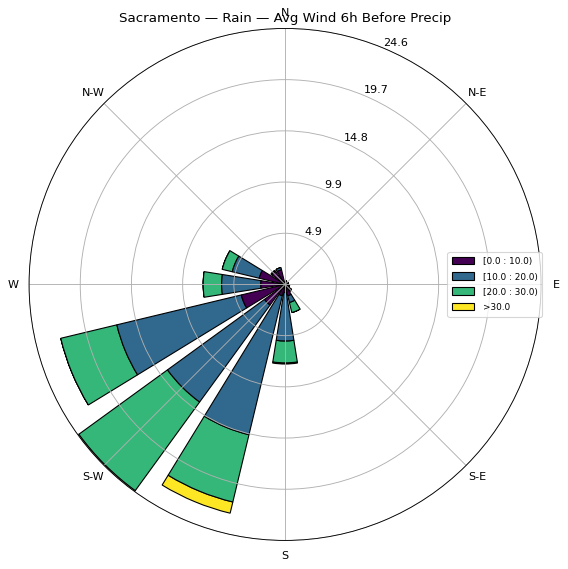

Saved: output/Sacramento_rain_6h_windrose.png


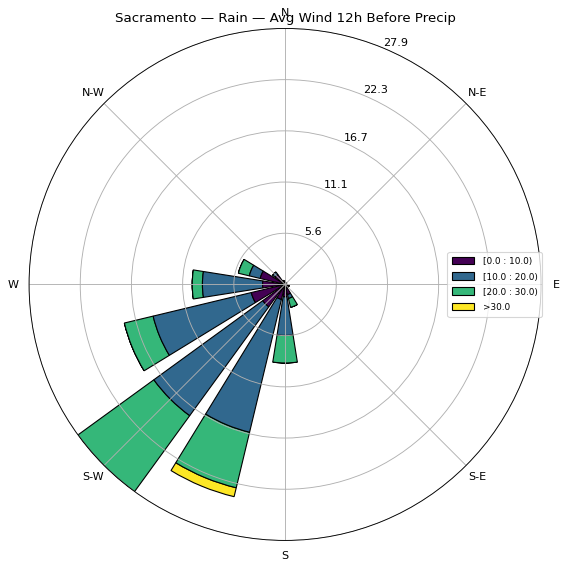

Saved: output/Sacramento_rain_12h_windrose.png
No snow events after filters; skipping.


In [10]:
for precip_type in (PRECIP_TYPES if PRECIP_TYPES else ["rain", "snow"]):
    # 1) Identify event timestamps by precip type (on the month-filtered base)
    dfp = filter_by_precip_type(flt, precip_type)
    event_times = dfp.loc[dfp[PRECIP_COL] > 0, TIMESTAMP_COL].sort_values()

    if event_times.empty:
        print(f"No {precip_type} events after filters; skipping.")
        continue


    for hours in HOURS_BEFORE:
        # 2) Build windows FROM FULL month-filtered base `flt` (keeps dry samples)
        lead = build_lead_wind_dataset_from(flt, event_times, hours)
        if lead.empty:
            print(f"No lead-window data for {precip_type} {hours}h; skipping.")
            continue

        title = f"{SITE_NAME} — {precip_type.capitalize()} — Avg Wind {hours}h Before Precip"
        save_path = f"{OUTPUT_DIR}/{SITE_NAME.replace(' ','_')}_{precip_type}_{hours}h_windrose.png"
        plot_windrose(lead, title, bins=WIND_SPEED_BINS, nsector=NSECTOR, save_path=save_path)
        print("Saved:", save_path)

# Optional diagnostic to confirm dry samples are included
try:
    first_ev = event_times.iloc[0]
    h0 = HOURS_BEFORE[0]
    start0 = first_ev - pd.Timedelta(hours=h0)
    cnt = flt[(flt[TIMESTAMP_COL] >= start0) & (flt[TIMESTAMP_COL] < first_ev)].shape[0]
    print(f"Diagnostic → first event {first_ev}, raw samples in {h0}h window: {cnt}")
except Exception:
    pass


## (Optional) Monthly summaries during precip events

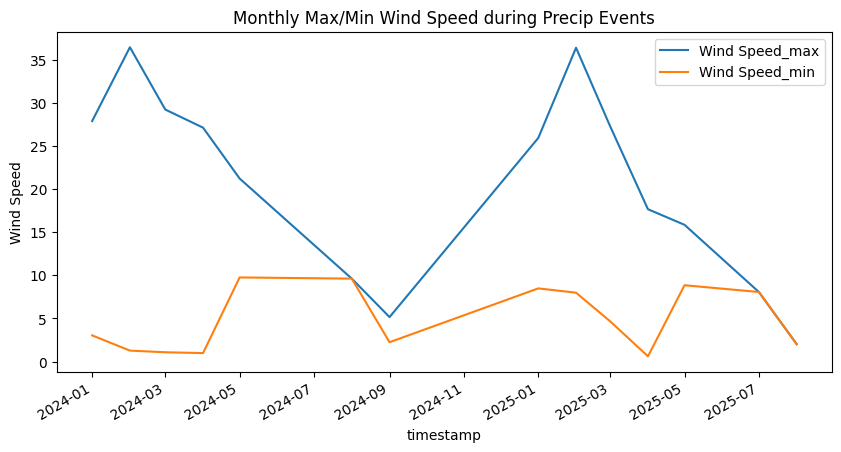

In [11]:

# Example monthly summary (during all precip, regardless of type)
dfp_all = filter_by_precip_type(flt, "both")
if not dfp_all.empty:
    g = dfp_all.groupby(dfp_all[TIMESTAMP_COL].dt.to_period('M')).agg(
        {WIND_SPEED_COL:['max','min'], PRECIP_COL:'mean'}
    )
    g.columns = ['_'.join(c) for c in g.columns]
    g.index = g.index.to_timestamp()
    ax = g[[f"{WIND_SPEED_COL}_max", f"{WIND_SPEED_COL}_min"]].plot(figsize=(10,5))
    ax.set_title("Monthly Max/Min Wind Speed during Precip Events")
    ax.set_ylabel("Wind Speed")
    plt.show()
else:
    print("No precipitation rows for monthly summary.")
